# In this notebook, we are going to build a gradient boosting algorithm:
Inspired [by](https://www.kaggle.com/prashant111/lightgbm-classifier-in-python)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
#import lightgbm as lgb
import pickle

from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection  import cross_validate, GridSearchCV
from sklearn  import metrics   #Additional scklearn functions
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from verstack.stratified_continuous_split import scsplit

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

## Defining training function:

## Load the Data:

In [2]:
very_light_data            = pd.read_csv("Data/inverted_OCR.csv")
very_light_data            = very_light_data.drop(columns = ['Index'])
#print(very_light_data.columns)
very_light_data.head()

,OTR,OCR,OMR,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,med_lifetime_cancel,90_p_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,mean_dt_TV1,NbSecondWithAtLeatOneTrade,type,Nber_shares_same_day
0,0.440000,0.120000,0.080000,0.000000,419.688500,10.722543,984.320560,23151.83800,25139.598,682.153260,984.32056,23151.8380,1,7,2.750000,9639.216031,4,0,5
1,0.589404,0.039735,0.046358,0.000074,0.003374,0.000204,8.768699,2671.48830,31278.357,11.866026,177.93991,21433.6840,1,17,5.933333,493.559196,15,0,5
2,0.674419,0.021142,0.008457,0.000071,0.000599,0.000129,5.725427,448.88360,30799.467,2.761036,187.99548,1953.6235,1,20,5.063492,163.954785,63,0,4
3,0.586207,0.068966,0.034483,0.000000,6.152666,0.000945,62.444176,19187.71900,19187.719,286.019320,286.01932,19187.7190,1,8,4.250000,1232.562133,4,0,3
4,0.658879,0.037383,0.000000,0.000071,0.001364,0.000146,2.225420,273.45676,23164.514,2.798452,1345.95280,23164.5140,1,19,3.710526,248.073927,38,0,1


## Train the model on all the data:

#### Splitting the data:

In [3]:
X_train, X_test, y_train, y_test = scsplit(very_light_data.drop(columns="type"), very_light_data['type'],
                                           stratify=very_light_data['type'],
                                           train_size=0.8, test_size=0.2,
                                            continuous = False) # tested

In [4]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [5]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.9927506819479683

In [6]:
best_model = gsearch1.best_estimator_

#### Parameter analysis:

In [20]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [8]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


#### Performance analysis on test set:

In [9]:
y_pred=best_model.predict(X_test)
y_pred

array([ 1, -1, -1, ..., -1, -1,  1])

In [10]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9936


Text(0, 0.5, 'Feature Importance Score')

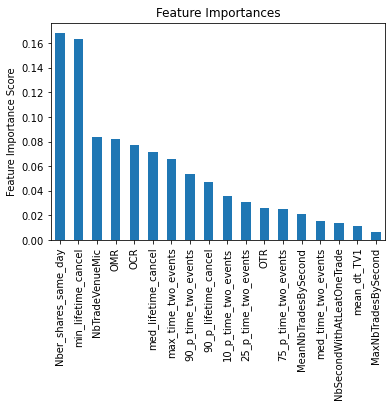

In [11]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

### Plot confusion matrix:

In [12]:
cm = confusion_matrix(y_test, y_pred)

In [13]:
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[10234    49    14]
 [   16  4451     3]
 [   41    13  6336]]


<AxesSubplot:>

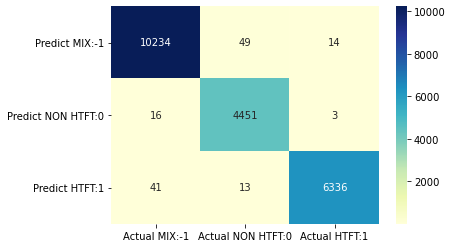

In [14]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual MIX:-1', 'Actual NON HTFT:0', 'Actual HTFT:1'], 
                                 index=['Predict MIX:-1', 'Predict NON HTFT:0', 'Predict HTFT:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99     10297
           0       0.99      1.00      0.99      4470
           1       1.00      0.99      0.99      6390

    accuracy                           0.99     21157
   macro avg       0.99      0.99      0.99     21157
weighted avg       0.99      0.99      0.99     21157



#### Save best model:

In [16]:
pickle.dump(best_model, open("models/18_features_gridsearch2.pkl", "wb"))

In [17]:
best_model = pickle.load(open("models/18_features_gridsearch2.pkl", "rb"))
best_model

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=700, random_state=10, subsample=0.8)

## Train the model on reduced data (PCA analysis):

In [18]:
X = very_light_data.drop(columns = 'type').iloc[:, [0,1,2,9,17,12,7,8,10,11]]
X.head()

,OTR,OCR,OMR,min_lifetime_cancel,Nber_shares_same_day,NbTradeVenueMic,90_p_time_two_events,max_time_two_events,med_lifetime_cancel,90_p_lifetime_cancel
0,0.440000,0.120000,0.080000,682.153260,5,1,23151.83800,25139.598,984.32056,23151.8380
1,0.589404,0.039735,0.046358,11.866026,5,1,2671.48830,31278.357,177.93991,21433.6840
2,0.674419,0.021142,0.008457,2.761036,4,1,448.88360,30799.467,187.99548,1953.6235
3,0.586207,0.068966,0.034483,286.019320,3,1,19187.71900,19187.719,286.01932,19187.7190
4,0.658879,0.037383,0.000000,2.798452,1,1,273.45676,23164.514,1345.95280,23164.5140


In [19]:
X_train2, X_test2, y_train2, y_test2 = scsplit(X, very_light_data['type'],
                                           stratify=very_light_data['type'],
                                           train_size=0.8, test_size=0.2,
                                            continuous = False) # tested

#### Fetching parameters:

In [35]:
try:
    best_params_gbm
except NameError:
    best_params_gbm = {'max_depth': 8,
                       'min_samples_leaf': 20,
                       'min_samples_split': 20,
                       'n_estimators': 700}
    print(best_params_gbm)
else:
    print(best_params_gbm)


{'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 700}


#### Defining the model:

GradientBoostingClassifier(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

In [22]:
clf2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=best_params_gbm['n_estimators'], min_samples_split=best_params_gbm['n_estimators'], min_samples_leaf= best_params_gbm['min_samples_leaf'], max_depth=best_params_gbm['max_depth'], max_features='sqrt',subsample=0.8,random_state=10)
clf2.fit(X_train2, y_train2)

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=700,
                           n_estimators=700, random_state=10, subsample=0.8)

In [23]:
y_pred2=clf2.predict(X_test2)
y_pred2

array([-1, -1, -1, ...,  0, -1,  0])

In [24]:
accuracy=accuracy_score(y_pred2, y_test2)
print('GBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test2, y_pred2)))

GBM Model accuracy score: 0.9905


#### Training accuracy:

In [25]:
# predict the results
y_pred_train2 = clf2.predict(X_train2)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train2, y_pred_train2)))

#### Compare train and test set accuracy

In [26]:
print('Training set score: {:.4f}'.format(clf2.score(X_train2, y_train2)))

print('Test set score: {:.4f}'.format(clf2.score(X_test2, y_test2)))

Training set score: 1.0000
Test set score: 0.9905


### Plot confusion matrix:

In [27]:
cm2 = confusion_matrix(y_test2, y_pred2)

In [28]:
print('Confusion matrix\n\n', cm2)

Confusion matrix

 [[10203    66    28]
 [   27  4431    12]
 [   47    20  6323]]


<AxesSubplot:>

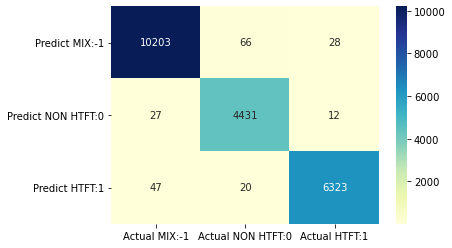

In [29]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm2, columns=['Actual MIX:-1', 'Actual NON HTFT:0', 'Actual HTFT:1'], 
                                 index=['Predict MIX:-1', 'Predict NON HTFT:0', 'Predict HTFT:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [30]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99     10297
           0       0.98      0.99      0.99      4470
           1       0.99      0.99      0.99      6390

    accuracy                           0.99     21157
   macro avg       0.99      0.99      0.99     21157
weighted avg       0.99      0.99      0.99     21157



#### Saving the data:

In [31]:
pickle.dump(clf2, open("models/10_features_gridsearch.pkl", "wb"))

In [32]:
clf2 = pickle.load(open("models/10_features_gridsearch.pkl", "rb"))

## Train the model on reduced data and seperated traders:

In [189]:
X_train3, X_test3, y_train3, y_test3 = pd.read_pickle("Processed_data/X_train_evenly_splitted_traders.pkl"), pd.read_pickle("Processed_data/X_test_evenly_splitted_traders.pkl"), pd.read_pickle("Processed_data/y_train_evenly_splitted_traders.pkl"), pd.read_pickle("Processed_data/y_test_evenly_splitted_traders.pkl")

In [190]:
X_train3.head()

,OTR,OCR,OMR,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,med_lifetime_cancel,90_p_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,mean_dt_TV1,NbSecondWithAtLeatOneTrade,Nber_shares_same_day
0,0.440000,0.120000,0.080000,0.000000,419.688500,10.722543,984.320560,23151.83800,25139.598,682.153260,984.32056,23151.8380,1,7,2.750000,9639.216031,4,5
1,0.589404,0.039735,0.046358,0.000074,0.003374,0.000204,8.768699,2671.48830,31278.357,11.866026,177.93991,21433.6840,1,17,5.933333,493.559196,15,5
2,0.674419,0.021142,0.008457,0.000071,0.000599,0.000129,5.725427,448.88360,30799.467,2.761036,187.99548,1953.6235,1,20,5.063492,163.954785,63,4
3,0.586207,0.068966,0.034483,0.000000,6.152666,0.000945,62.444176,19187.71900,19187.719,286.019320,286.01932,19187.7190,1,8,4.250000,1232.562133,4,3
4,0.658879,0.037383,0.000000,0.000071,0.001364,0.000146,2.225420,273.45676,23164.514,2.798452,1345.95280,23164.5140,1,19,3.710526,248.073927,38,1


In [191]:
X_train3 = X_train3[X_train2.columns]
X_test3 = X_test3[X_train2.columns]

#### Defining the model:

In [192]:
clf3 = lgb.LGBMClassifier(boosting_type='gbdt')
clf3.fit(X_train3, y_train3)

LGBMClassifier()

In [193]:
y_pred3=clf3.predict(X_test3)
y_pred3

array([ 1,  1,  1, ..., -1, -1, -1])

In [194]:

accuracy=accuracy_score(y_pred3, y_test3)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_pred3, y_test3)))

LightGBM Model accuracy score: 0.7565


#### Training accuracy:

In [195]:
# predict the results
y_pred_train3 = clf3.predict(X_train3)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train2, y_pred_train2)))

#### Compare train and test set accuracy

In [196]:
print('Training set score: {:.4f}'.format(clf3.score(X_train3, y_train3)))

print('Test set score: {:.4f}'.format(clf3.score(X_test3, y_test3)))

Training set score: 0.9965
Test set score: 0.7565


### Plot confusion matrix:

In [197]:
cm3 = confusion_matrix(y_test3, y_pred3)

In [198]:
print('Confusion matrix\n\n', cm3)

Confusion matrix

 [[8096  729 2045]
 [ 210 5423    3]
 [2526    1 3609]]


<AxesSubplot:>

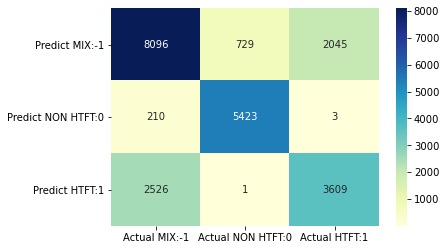

In [199]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm3, columns=['Actual MIX:-1', 'Actual NON HTFT:0', 'Actual HTFT:1'], 
                                 index=['Predict MIX:-1', 'Predict NON HTFT:0', 'Predict HTFT:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [200]:
print(classification_report(y_test3, y_pred3))

              precision    recall  f1-score   support

          -1       0.75      0.74      0.75     10870
           0       0.88      0.96      0.92      5636
           1       0.64      0.59      0.61      6136

    accuracy                           0.76     22642
   macro avg       0.76      0.77      0.76     22642
weighted avg       0.75      0.76      0.75     22642



#### Saving the data:

In [201]:
pickle.dump(clf3, open("models/10_feature_LGBM_seperated_traders.pkl", "wb"))

In [179]:
#clf3 = pickle.load(open("models/10_feature_LGBM_seperated_traders.pkl", "rb"))